<a href="https://colab.research.google.com/github/davidolima/car-model-classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho final - Curso Deep Learning
### Prof. Luciano de Rebouças
### Aluno: David de Oliveira Lima

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [34]:
!mv /content/vgg-19-history-* "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# !kaggle datasets download -d peterjun/car196 -p "/content/drive/MyDrive/Colab Notebooks"
# %cd "/content/drive/MyDrive/Colab Notebooks"
# !unzip car196.zip
# !rm car196.zip


In [3]:
!pip install tensorflow_ranking scikit-learn;

In [4]:
# Core
import tensorflow as tf
import tensorflow.keras as keras

# Redes e optimizers
from keras.applications import VGG19, ResNet50V2, EfficientNetB0, InceptionV3
from keras.optimizers import Adam, SGD

# Keras
from keras import Sequential
from keras.utils import to_categorical, image_dataset_from_directory, split_dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K

#tfr
import tensorflow_ranking as tfr

# Etc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from sklearn.model_selection import KFold
from tensorflow_datasets import as_numpy
from sklearn.utils import shuffle
from PIL import Image

# Parâmetros

In [5]:
n_classes = 196
epochs = 50
batch_size = 64
n_folds = 3
img_size = (224,224)
es_patience = 8
root = "/content/drive/MyDrive/Colab Notebooks/car196/"
val_split = 0.2
channels = 3

# Inicialização

## Funções para gráficos

In [20]:
def plotMetrics(hist):
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['val_precision_m'])
    plt.plot(hist.history['val_recall_m'])
    plt.plot(hist.history['val_f1_m'])
    plt.ylabel('metrics')
    plt.xlabel('epoch')
    plt.legend(['Accuracy', 'Precision', 'Recall', 'F1_score'], loc='lower right')
    plt.show()

def plotHist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plotPR(hist):
    plt.plot(hist.history['recall_m'],hist.history['precision_m'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

def plotFoldsMetrics(hists):
  """
  Plotar métricas para três folds
  """
  for i in range(1,4):
    plt.subplot(3,1,i)
    plt.title(f'Fold {i} - Metrics')
    plotMetrics(hists[i-1])
  plt.show()

def plotFoldsHists(hists):
  """
  Plotar acuracia de treino e validação para três folds
  """
  for i in range(1,4):
    plt.subplot(3,1,i)
    plt.title(f'Fold {i} - Model accuracy')
    plotHist(hists[i-1])
  plt.show()

def plotFoldsPR(hists):
  """
  Plotar Precision x Recall para três folds
  """
  for i in range(1,4):
    plt.subplot(3,1,i)
    plt.title(f'Fold {i} - Precision x Recall')
    plotPR(hists[i-1])
  plt.show()

## Métricas

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Carregamento de dados

In [8]:
def carregarDados(dir:str, resize_shape:tuple=None, shuffle_data:bool=True, seed:int=None, return_map:bool=False):
  """
  Função para criar um data set a partir de uma pasta com labels em sua estrutura.
  Apesar de modular, esta função foi feita para o carragemento do dataset cars196,
  que tem como estrutura:
  cars196:
     - train
        - classe 1
        ...
        - classe 196
     - test
        ...
        - classe 196
  Retorna a tupla (inputs, labels), onde inputs e labels são listas.
  """

  inputs, labels = [], []
  label_map = {}
  classes = []

  root = dir
  dir = os.listdir(root)

  for f in dir:
    if os.path.isdir(root + f):
      classes.append(f)

  print(f"{len(classes)} classes encontradas.")

  # codificar classes em números
  for i, classe in enumerate(classes):
    label_map[classe] = i

  # extrair imagens de cada classe com suas respectivas labels
  for classe in classes:
    for image in os.listdir(root + classe):
      image = Image.open(root+classe+"/"+image)

      # Redimensionar
      if resize_shape:
        image = image.resize(resize_shape)

      inputs.append(np.array(image))
      labels.append(label_map[classe])

  print(f"{len(inputs)} imagens carregadas.")

  # Embaralhar dados
  if shuffle_data:
    inputs, labels = shuffle(inputs, labels, random_state=(None if not seed else seed))

  #inputs, labels = np.asarray(inputs,dtype=np.int8), np.asarray(labels,dtype=np.uint8)
  if not return_map:
    return (inputs, labels)
  return (inputs, labels), label_map

In [9]:
# Carregar dataset
print("Training images: ",end='')
(x_train, y_train), label_map = carregarDados(root + 'train/',resize_shape=img_size,return_map=True)
y_train = to_categorical(y_train)


Training images: 196 classes encontradas.
8144 imagens carregadas.


In [10]:
print("Test images: ",end='')
ds_test = image_dataset_from_directory(
    root + "test/",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
)

Test images: Found 8041 files belonging to 196 classes.


In [11]:
x_train = np.asarray(list(map(np.asarray,x_train)))
y_train = np.asarray(list(map(np.asarray,y_train)))

## Augmentation

In [12]:
# Augmentation
resize_and_rescale = tf.keras.Sequential([
  Resizing(img_size[0], img_size[1]),
  Rescaling(1./255)
])

augmentation = keras.Sequential([
    # Resizing(img_size[0],img_size[1]),
    # Rescaling(1./255),
    RandomRotation(0.30),
    RandomFlip("horizontal"),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Treinamento das redes

## VGG19

### Inicialização

In [13]:
adam = Adam(.001,
           beta_1=0.9,
           beta_2=0.999,
           )

sgd = SGD(
    5e-3,
    momentum=.9
)
criterion = categorical_crossentropy
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min', verbose=1,
                           patience=es_patience,
                           restore_best_weights = True
                           )

In [14]:
base = VGG19(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

for l in base.layers:
  l.trainable = False

# model_1.build((None, img_size[0], img_size[1], channels))
# model_1.summary()

80134624/80134624 [==============================] - 0s 0us/step


### Treinamento

In [15]:
# Training
kfold = KFold(n_splits=n_folds, shuffle=True)

fold_no = 1
fold_histories = []

for train, validation in kfold.split(x_train, y_train):
  checkpoint = ModelCheckpoint(f"/content/trab-final-best-vgg-{fold_no}.hdf5",
                                monitor='val_loss', verbose=1,
                                save_best_only=True,
                                mode='auto')

  model_1 = Sequential([
    resize_and_rescale,
    augmentation,
    base,
    Flatten(),
    Dense(n_classes, activation='softmax'),
  ])

  model_1.compile(loss=criterion,
                optimizer=sgd,
                metrics=["accuracy",
                        recall_m,
                        precision_m,
                        f1_m,
                        tfr.keras.metrics.MeanAveragePrecisionMetric()],
                )

  print('------------------------------------------------------------------------')
  print('> Fold', fold_no)
  history = model_1.fit(x_train[train], y_train[train],
                        validation_data=(x_train[validation],y_train[validation]),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[keras.callbacks.History(), early_stop, checkpoint])


  fold_histories.append(history)

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
> Fold 1
Epoch 1/50
85/85 [==============================] - ETA: 0s - loss: 7.1341 - accuracy: 0.0085 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - mean_average_precision_metric: 0.0381
Epoch 1: val_loss improved from inf to 7.37483, saving model to /content/trab-final-best-vgg-1.hdf5
85/85 [==============================] - 71s 622ms/step - loss: 7.1341 - accuracy: 0.0085 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - mean_average_precision_metric: 0.0381 - val_loss: 7.3748 - val_accuracy: 0.0110 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_mean_average_precision_metric: 0.0452
Epoch 2/50
85/85 [==============================] - ETA: 0s - loss: 7.2611 - accuracy: 0.0254 - recall_m: 7.3529e-04 - precision_m: 0.0304 - f1_m: 0.0014 - mean_average_precision_metric: 0.0686
Epoch 2: val_loss improved from 7.37483 to 7.27204, saving

### Avaliação de resultados

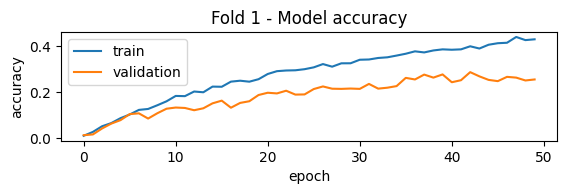

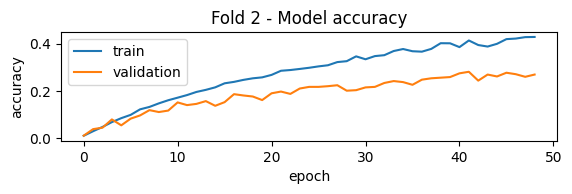

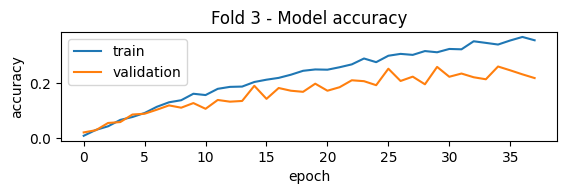

In [16]:
plotFoldsHists(fold_histories)

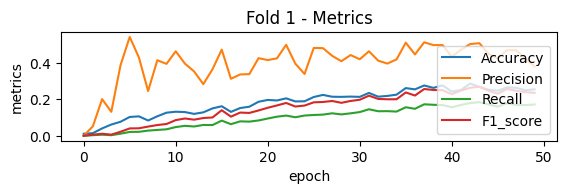

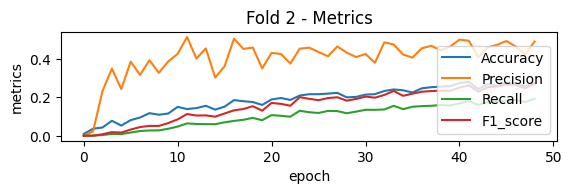

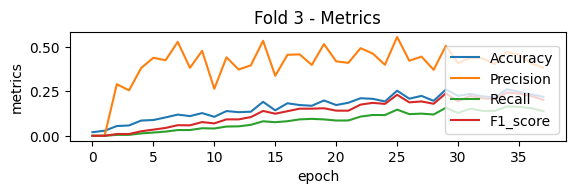

In [17]:
plotFoldsMetrics(fold_histories)

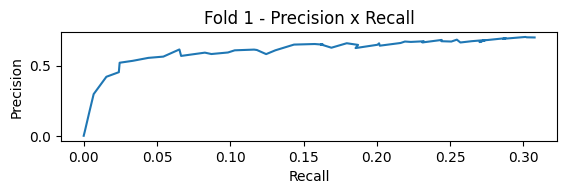

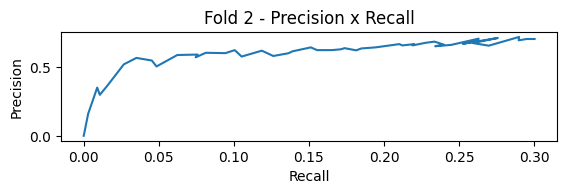

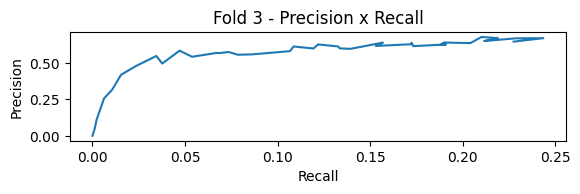

In [21]:
plotFoldsPR(fold_histories)

In [33]:
# Salvar Históricos
import pickle
for i in range(len(fold_histories)):
  with open(f'/content/vgg-19-history-fold-{i+1}.pickle', 'wb') as f:
    pickle.dump(fold_histories[i].history, f)

### Avaliação do best model

In [38]:
# Carregar e avaliar best model
# Best model escolhido levando em consideração seu f1-score e acurácia.
bm_path = "/content/drive/MyDrive/Colab Notebooks/results/trab-final-best-vgg-1.hdf5"
best_model = keras.models.load_model(bm_path,
                                    custom_objects={"recall_m": recall_m,
                                                    "precision_m": precision_m,
                                                    "f1_m": f1_m})
bm_evaluation=best_model.evaluate(ds_test,
                                  verbose=2,
                                  batch_size=batch_size,
                                  callbacks=[keras.callbacks.History()])

126/126 [==============================] - 706s 6s/step - loss: 3.7776 - accuracy: 0.2843 - recall_m: 0.1772 - precision_m: 0.4946 - f1_m: 0.2595 - mean_average_precision_metric: 0.4023


In [44]:
bm_evaluation

[3.777566432952881,
 0.284292995929718,
 0.1771831512451172,
 0.49464505910873413,
 0.259541779756546,
 0.40225186944007874]

## ResNet50V2

In [ ]:
base = ResNet50V2(
    include_top=False,
    weights="imagenet", # transfer learning da imagenet
    input_tensor=None,
    input_shape=(img_size[0],img_size[1],3),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax',
)

for l in base.layers:
  l.trainable = False

model_3 = Sequential([
    resize_and_rescale,
    augmentation,
    base,
    Flatten(),
    Dense(n_classes, activation='softmax'),
])

model_3.build((None, img_size[0], img_size[1], channels))
model_3.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 196)               19669188  
                                                                 
Total params: 43,233,988
Trainable params: 19,669,188
Non-trainable params: 23,564,800
__________________________________

In [ ]:
# Training
checkpoint = ModelCheckpoint(f"/content/trab-final-best-resnet50v2.hdf5",
                            monitor='loss', verbose=1,
                            save_best_only=True,
                            mode='auto')

model_3.compile(loss=criterion,
            optimizer=sgd,
            metrics=["accuracy",
                     recall_m,
                     precision_m,
                     f1_m],
            )

history_3 = model_3.fit(ds_train,
                  validation_data=ds_val,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  callbacks=[keras.callbacks.History(), early_stop, checkpoint])

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 83.6123 - accuracy: 0.1308 - recall_m: 0.1305 - precision_m: 0.1309 - f1_m: 0.1307
Epoch 1: loss improved from inf to 83.61230, saving model to /content/trab-final-best-resnet50v2.hdf5
102/102 [==============================] - 49s 419ms/step - loss: 83.6123 - accuracy: 0.1308 - recall_m: 0.1305 - precision_m: 0.1309 - f1_m: 0.1307 - val_loss: 82.0055 - val_accuracy: 0.1136 - val_recall_m: 0.1117 - val_precision_m: 0.1127 - val_f1_m: 0.1122
Epoch 2/50
102/102 [==============================] - ETA: 0s - loss: 79.4492 - accuracy: 0.1711 - recall_m: 0.1710 - precision_m: 0.1715 - f1_m: 0.1712
Epoch 2: loss improved from 83.61230 to 79.44920, saving model to /content/trab-final-best-resnet50v2.hdf5
102/102 [==============================] - 50s 484ms/step - loss: 79.4492 - accuracy: 0.1711 - recall_m: 0.1710 - precision_m: 0.1715 - f1_m: 0.1712 - val_loss: 81.2740 - val_accuracy: 0.1284 - val_recall_m: 0.1271 - val_prec

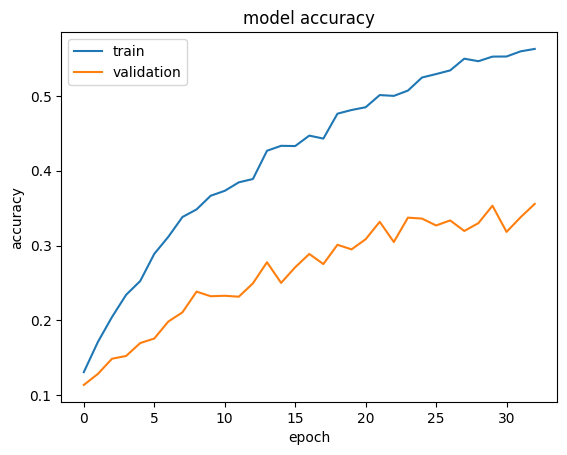

In [ ]:
plotHist(history_3)

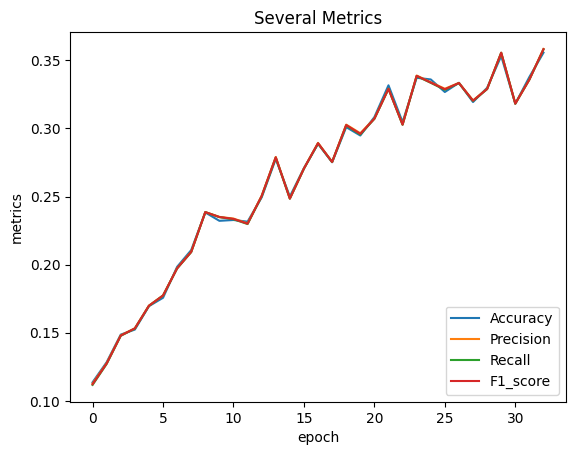

In [ ]:
plotMetrics(history_3)

In [ ]:
model_test_acc_3=model_3.evaluate(ds_test,batch_size=64)

126/126 [==============================] - 38s 283ms/step - loss: 66.3447 - accuracy: 0.3368 - recall_m: 0.3362 - precision_m: 0.3368 - f1_m: 0.3365


# Referências

 - [Choose an activation function for deep learning - Machine Learning Mastery](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)
 - [Data augmentation - Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation)
 - [Transfer learning with VGG16 and VGG19, the simpler way!](https://koushik1102.medium.com/transfer-learning-with-vgg16-and-vgg19-the-simpler-way-ad4eec1e2997)
 - [mAP (mean Average Precision) for Object Detection](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)
 - [Visão Computacional::Métricas::Mean Average Precision - LAPiX](https://lapix.ufsc.br/ensino/visao/visao-computacionaldeep-learning/visao-computacionalmetricasmean-average-precision/#Calculando_a_precisao_media_Average_Precision_8211_AP)
 - [Model - Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
 - [christianversloot - machine-learning-articles
/how-to-use-k-fold-cross-validation-with-keras.md](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md)